In [1]:
import random

import gym
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (6, 6)

In [2]:
random.seed(678)
np.random.seed(678)

In [3]:
%load_ext autoreload
%autoreload 2

from notebook_util import plot_v_function, evaluate_td_learning, plot_stat
from rl_learning import SimplePolicy, MonetCarloSimulation, Sarsa, BlackjackEnvDouble, ExtendedAction

# Часть первая

## Простая стратегия

In [4]:
policy = SimplePolicy()
simulator = MonetCarloSimulation(gym.make("Blackjack-v0"), policy)

In [5]:
rewards = simulator.simulate(10_000)

100%|██████████| 10000/10000 [00:02<00:00, 4842.62it/s]


In [6]:
rows = []
for state, expected_reward in rewards.items():
    rows.append(state + (expected_reward,))

stat = pd.DataFrame(rows, columns=["player_sum", "dealer_open_card", "usable_ace", "reward"])
del rows

In [7]:
usable_ace_stat = stat[stat["usable_ace"] == True]
not_usable_ace_stat = stat[stat["usable_ace"] == False]

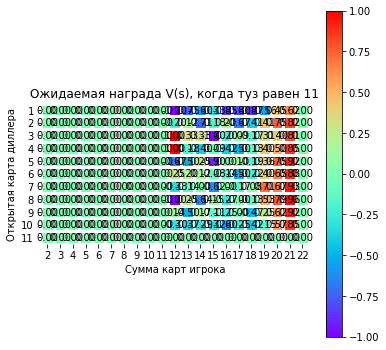

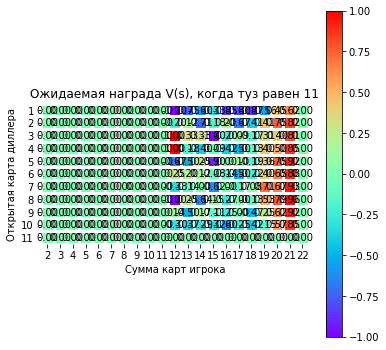

In [8]:
plot_v_function(usable_ace_stat, "Ожидаемая награда V(s), когда туз равен 11")

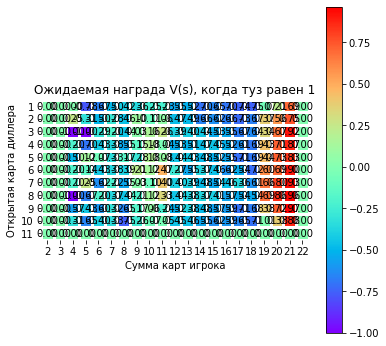

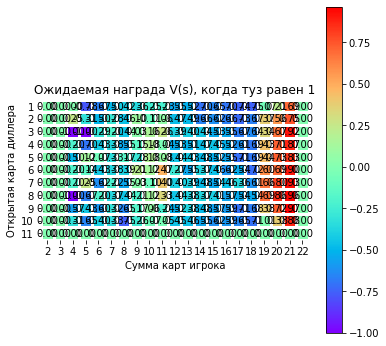

In [9]:
plot_v_function(not_usable_ace_stat, "Ожидаемая награда V(s), когда туз равен 1")

## Q-обучение

In [10]:
gama_values = np.linspace(0.5, 1, 4)
alpha_values = np.linspace(1e-2, 0.5, 3)
num_train_episodes = 20_000
num_test_episodes = 10
epsilon = 0.01

env = gym.make("Blackjack-v0")

In [11]:
train_stat, test_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values, epsilon=epsilon,
    num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes, env=env)

(<Figure size 432x432 with 2 Axes>,
 <Figure size 432x432 with 1 Axes>,
 <Figure size 432x432 with 2 Axes>)

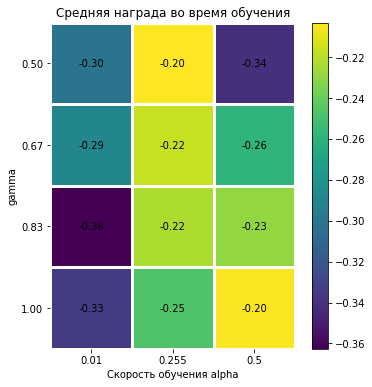

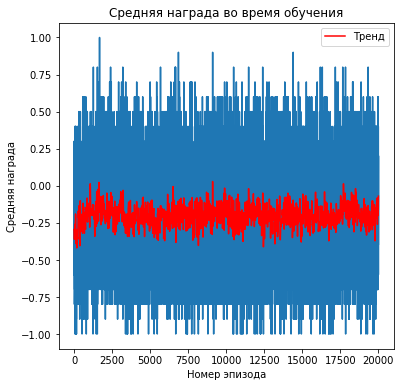

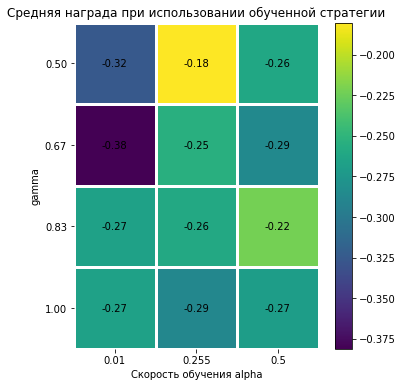

In [12]:
plot_stat(alpha_values, gama_values, train_stat, test_stat)

## Sarsa

In [13]:
train_stat, test_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values, epsilon=epsilon, num_train_episodes=num_train_episodes,
    num_test_episodes=num_test_episodes, learning_cls=Sarsa, env=env)

(<Figure size 432x432 with 2 Axes>,
 <Figure size 432x432 with 1 Axes>,
 <Figure size 432x432 with 2 Axes>)

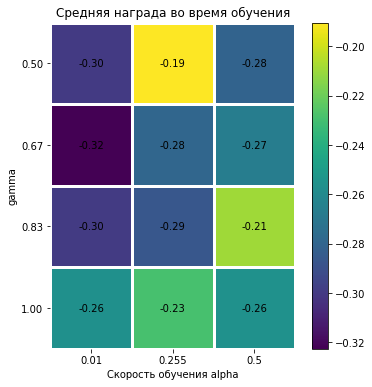

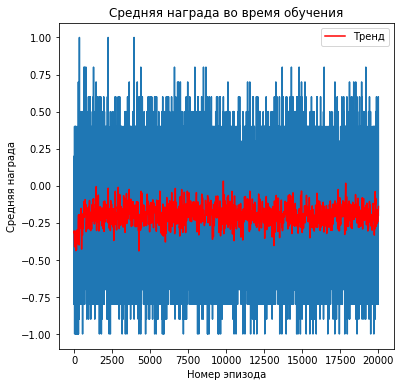

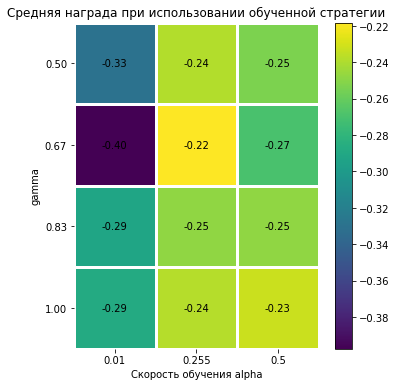

In [14]:
plot_stat(alpha_values, gama_values, train_stat, test_stat)

# Часть вторая

In [15]:
env = BlackjackEnvDouble()

## Q-обучение

In [16]:
train_stat, test_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values,
    epsilon=epsilon, num_train_episodes=num_train_episodes, num_test_episodes=num_test_episodes, 
    env=env, action_space=ExtendedAction)

(<Figure size 432x432 with 2 Axes>,
 <Figure size 432x432 with 1 Axes>,
 <Figure size 432x432 with 2 Axes>)

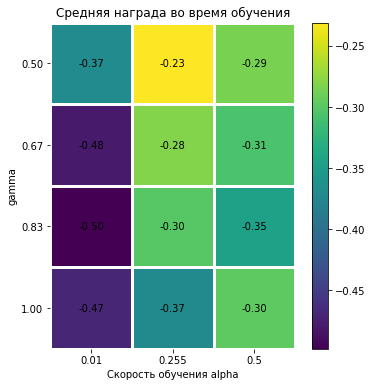

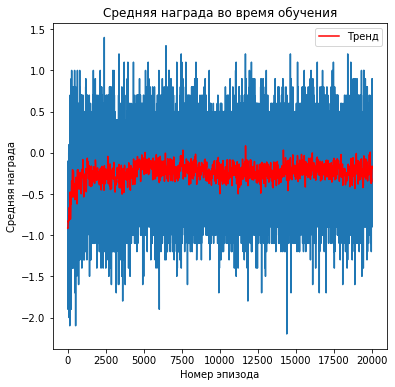

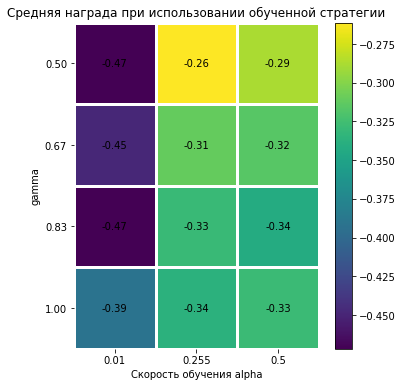

In [17]:
plot_stat(alpha_values, gama_values, train_stat, test_stat)

## Sarsa

In [18]:
train_stat, test_stat = evaluate_td_learning(
    alpha_values=alpha_values, gamma_values=gama_values, epsilon=epsilon, num_train_episodes=num_train_episodes, 
    num_test_episodes=num_test_episodes, learning_cls=Sarsa, env=env, action_space=ExtendedAction)

(<Figure size 432x432 with 2 Axes>,
 <Figure size 432x432 with 1 Axes>,
 <Figure size 432x432 with 2 Axes>)

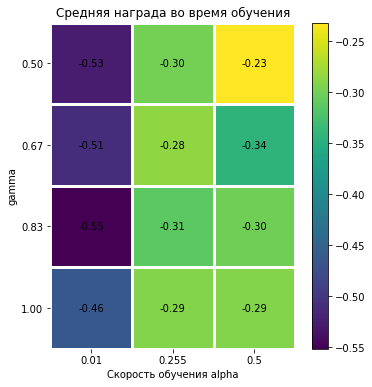

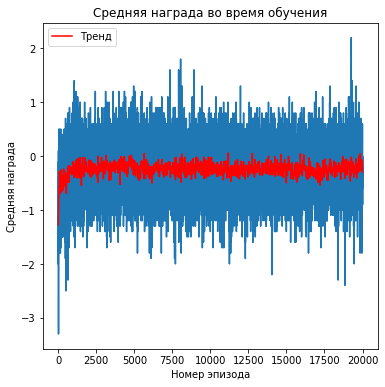

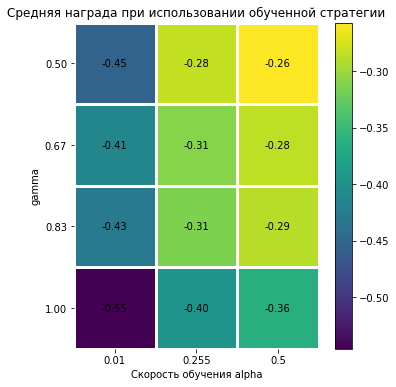

In [19]:
plot_stat(alpha_values, gama_values, train_stat, test_stat)